# a spring coupled mass simulator to create positions of mechanisms and purviews of a CES 

In [1]:
import numpy as np
import math
import pickle as pkl

from pyphi import visualize as viz
from pyphi import relations as rel

import matplotlib.pyplot as plt
import string

import random


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [115]:
def strip_punct(s):
    return str(s.translate(str.maketrans({key: None for key in string.punctuation})).replace(' ', ''))

def update_position_and_velocity(position,velocity,force,delta,mass=1):
    acceleration = force/mass
    velocity = velocity+acceleration*delta
    position = position+velocity*delta
    return position, velocity

def compute_force(self_position,other_positions,spring_constants,velocity,friction_factor):
    spring_force = np.sum([-k*(self_position-position) for k,position in zip(spring_constants,other_positions)])
    friction_force = -velocity*friction_factor
    return spring_force + friction_force
    
def get_interactions(ces,rels,adjustment_factor=1):
    
    separated_ces = rel.separate_ces(ces)
    N = len(ces)
    M = len(separated_ces)
    
    # denote what components each purview will be affected by 
    # first the mechanisms
    features_mechs = np.zeros((M,N))
    for i in range(N):
        features_mechs[2*i:2*i+2, i] = 1
        
    # next the relations
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    # features now contains information about any distinction or relation each purview is associated to
    # next, we exchange the 1's with phi values
    # frist for distinctions
    for i in range(M):
        features_mechs[i,:] *= separated_ces[i].phi
        
    for i in range(len(rels)):
        features_rels[:,i] *= rels[i].phi/len(rels[i].relata)
    
    # getting the interactions between constituents
    interactions = np.zeros((N+M,N+M))
    
    # filling with mechanism-purview interactions
    interactions[N:,:N] = features_mechs
    interactions[:N,N:] = np.transpose(features_mechs)
    
    # now for the purview-purview interactions
    purview_purview = np.zeros((M,M))
    for i,feature in enumerate(features_rels):
        for r in feature.nonzero()[0]:
            for j in features_rels[:,r].nonzero()[0]:
                if not i==j:
                    purview_purview[i,j] += feature[r]
                    purview_purview[j,i] += feature[r]
                    
    #renormalizing to have same max as mechanisms interactions
    purview_purview = adjustment_factor*np.max(interactions[N:,:N])*purview_purview/(np.max(np.sum(purview_purview,axis=1)))
    
    interactions[N:, N:] = purview_purview
    
    return interactions


def equilibriate(ks,purviews,x,y,z=None,v_x=None,v_y=None,v_z=None,friction_factor=2,T=100,delta=0.1):
    if z is None:
        z=np.zeros(len(x))
    if v_x is None:
        v_x=np.zeros(len(x))
    if v_y is None:
        v_y=np.zeros(len(x))
    if v_z is None:
        v_z=np.zeros(len(x))
        
    path_x = []
    path_y = []
    path_z = []
    for t in range(T):
        path_x.append(list(x))
        path_y.append(list(y))
        path_z.append(list(z))
        for i in purviews:
            x[i],v_x[i] = update_position_and_velocity(x[i],v_x[i],compute_force(x[i],x,ks[i],v_x[i],friction_factor),delta)
            y[i],v_y[i] = update_position_and_velocity(y[i],v_y[i],compute_force(y[i],y,ks[i],v_y[i],friction_factor),delta)
            z[i],v_z[i] = update_position_and_velocity(z[i],v_z[i],compute_force(z[i],z,ks[i],v_z[i],friction_factor),delta)
        
    return x, y, z, path_x, path_y, path_z

def initialize_positions(ces, center=(1,1), z=0, radius=1):
    mechs = viz.regular_polygon(len(ces), center=center, angle=0, z=0, radius=radius, scale=1)
    purviews = viz.regular_polygon(2*len(ces), center=center, angle=math.pi / (len(ces)), z=0, radius=radius, scale=0.9)
    return np.array(mechs+purviews)

# Chapter 3 system

In [86]:
with open(r"ch3_ces.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"ch3_rels.pkl", "rb") as f:
    rels = pkl.load(f)
    
with open(r"ch3_subsystem.pkl", "rb") as f:
    system = pkl.load(f)

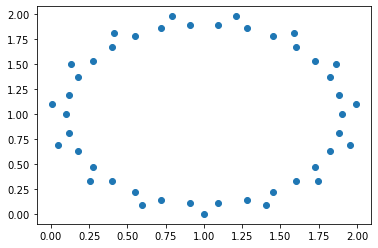

In [118]:
xyz = initialize_positions(ces)
plt.scatter(xyz[:,0],xyz[:,1])
plt.show()

In [125]:


k = get_interactions(ces,rels,0.5)

purview_indices = tuple(range(15,45))
x,y,z,px,py,pz = equilibriate(k,purview_indices,xyz[:,0],xyz[:,1],T=1000,friction_factor=0.2)


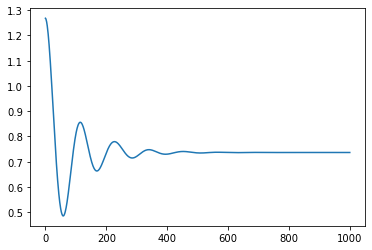

In [126]:
plt.plot(np.array(px)[:,-12])
plt.show()

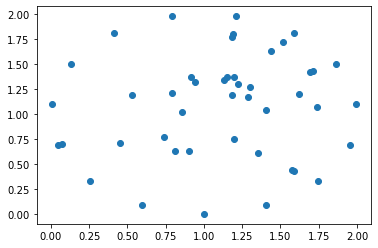

In [127]:
plt.scatter(x,y)
plt.show()

In [5]:
labels = [strip_punct(str(system.indices2nodes(c.mechanism))) for c in ces]+[strip_punct(str(system.indices2nodes(c.purview))) for c in rel.separate_ces(ces)]

mech_coords = [x[:len(ces)],y[:len(ces)],np.zeros(len(ces))]
purv_coords = np.array([
    [x[len(ces):][i],y[len(ces):][i],np.zeros(2*len(ces))[i]]
     for i in range(2*len(ces))
])

In [7]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='ch3_spring',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels=True,
)

Computing edges:   0%|          | 0/201 [00:00<?, ?it/s]

Computing triangles:   0%|          | 0/677 [00:00<?, ?it/s]

# Space

In [128]:
with open(r"space_ces_with_nodelabels.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"space_subsystem.pkl", "rb") as f:
    system = pkl.load(f)
    
with open(r"space_2relations.pkl", "rb") as f:    
    #This file includes all 2-relations (~30k)
    tworels = pkl.load(f)  
sample2rels = random.sample(tworels,5000)

In [129]:
rels = sample2rels
rels = tworels

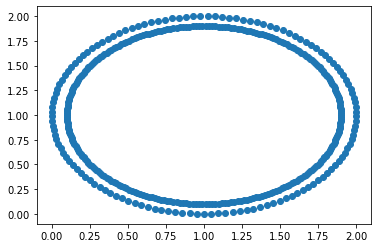

In [159]:
xyz = initialize_positions(ces)

plt.scatter(xyz[:,0],xyz[:,1])
plt.show()

In [164]:


k = get_interactions(ces,rels,adjustment_factor=0.1)

purview_indices = tuple(range(len(ces),len(ces)*3))
x,y,z,px,py,pz = equilibriate(k,purview_indices,xyz[:,0],xyz[:,1],T=100,delta=1,friction_factor=1)


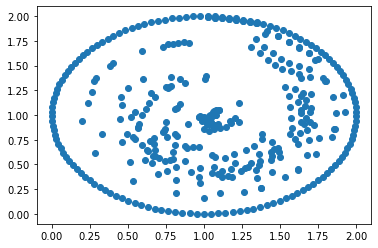

In [165]:

plt.scatter(x,y)
plt.show()

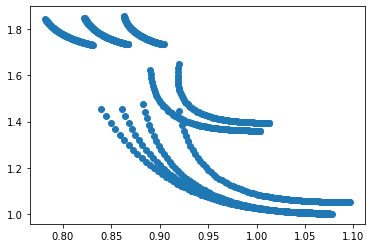

In [166]:
plt.scatter(np.array(px)[:,-10:-1],np.array(py)[:,-10:-1])

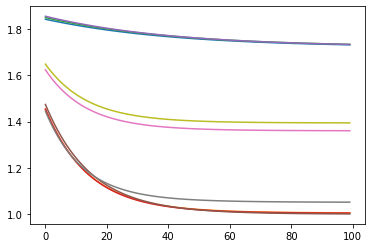

In [167]:
plt.plot(np.array(py)[:,-10:-1])

In [66]:
labels = [strip_punct(str(system.indices2nodes(c.mechanism))) for c in ces]+[strip_punct(str(system.indices2nodes(c.purview))) for c in rel.separate_ces(ces)]

mech_coords = [x[:len(ces)],y[:len(ces)],np.zeros(len(ces))]
purv_coords = np.array([
    [x[len(ces):][i],y[len(ces):][i],np.zeros(2*len(ces))[i]]
     for i in range(2*len(ces))
])

In [67]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='space_spring_2rels_5k_no_edge',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels='legendonly',
                             show_edges=False,
                            )

# toy example to test code

In [151]:
k = [
    [0,1,2,0,1],
    [1,0,3,2,3],
    [2,3,0,1,2],
    [0,2,1,0,1],
    [1,3,2,1,0]
]
x,y,z,px,py,pz = equilibriate(k,(2,3),[2,1,2,3,4],[0,1,2,3,4],friction_factor=2,delta=0.1)

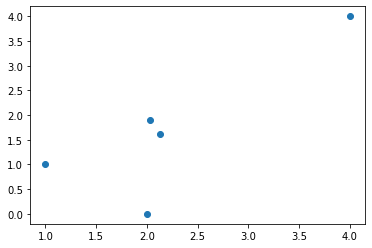

In [152]:
plt.scatter(x,y)

In [153]:
x

[2, 1, 2.129034787874921, 2.0322497560161437, 4]

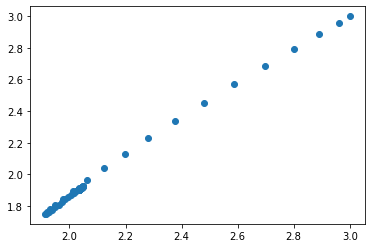

In [154]:
plt.scatter(np.array(px)[:,-2],np.array(py)[:,-2])

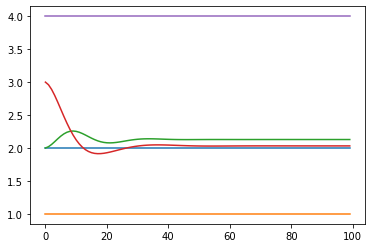

In [155]:
plt.plot(np.array(px))